## MNIST Classifier 

### By: Abrahim H.

In [26]:
import torch   
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset  
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import torch.nn.functional as F 
import tqdm

In [2]:
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)

Using device: cuda:2


### Importing Datset

In [19]:
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
]) 

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

batch_size = 32  

train_loader = DataLoader(
    mnist_trainset,
    batch_size = 32,
    shuffle = False
) 

test_loader = DataLoader( 
    mnist_testset,
    batch_size = 32,
    shuffle = False
)


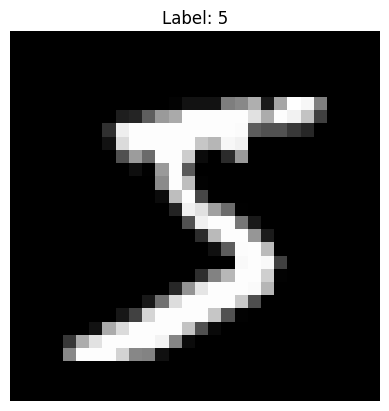

In [20]:
image, label = mnist_trainset[0]  

plt.imshow(image.squeeze(), cmap='gray') 
plt. title(f"Label: {label}") 
plt.axis('off') 
plt.show() 

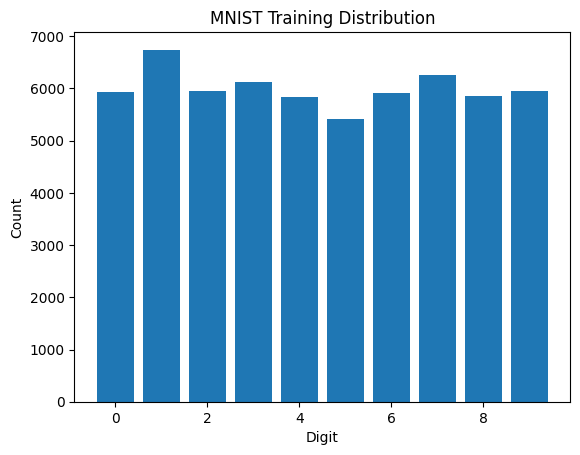

In [21]:
counts = torch.bincount(mnist_trainset.targets) 
plt.bar(range(10), counts) 
plt.xlabel('Digit') 
plt.ylabel('Count') 
plt.title('MNIST Training Distribution') 
plt.show() 

### Building The Model

In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()   
        
        #Setup the two convolution layers 
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            )  
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            )   
        
        #Add dropout and our fully connectled layers 
        self.dropout = nn.Dropout(0.5) 
        self.fc1 = nn.Linear(64*7*7,128) 
        self.fc2 = nn.Linear(128,10)
    
    def forward(self,x):  
        #Run our images thorugh the layers
        x = self.conv_block1(x)  
        x = self.conv_block2(x)  
        #Flatten 
        x = torch.flatten(x,1)   
        #Throw in dropout layer + fully connected layers 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x) 
        x = self.fc2(x) 
        return x   
    
    def train_model(self, train_loader, val_loader=None, epochs=10, lr=0.001, device=DEVICE): 
        self.to(device) 
        optimizer = optim.Adam(self.parameters(), lr=lr)  
        criterion = nn.CrossEntropyLoss()  
        train_losses, val_losses = [], [] 
        train_accs, val_accs = [], []

        for epoch in range(epochs): 
            self.train() 
            running_loss = 0 
            correct = 0 
            total = 0 

            for images, labels in train_loader: 
                images, labels = images.to(device), labels.to(device) 
                optimizer.zero_grad() 
                outputs = self(images) 
                loss = criterion(outputs, labels) 
                loss.backward() 
                optimizer.step() 

                running_loss += loss.item() * images.size(0) 
                preds = outputs.argmax(dim=1) 
                correct += (preds == labels).sum().item() 
                total += labels.size(0) 

            train_loss = running_loss / total 
            train_acc = correct / total 
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)   
            train_losses.append(train_loss) 
            train_accs.append(train_acc)    

            if val_loader: 
                vall_loss, val_acc = self.evaluate(val_loader, criterion, device) 
                val_losses.append(val_loss) 
                val_accs.append(val_acc) 
            else: 
                val_loss, val_acc = 0, 0   
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        plt.figure(figsize=(12,5)) 

        plt.subplot(1,2,1) 
        plt.plot(train_losses, label = 'Train Loss') 
        if val_loader: plt.plot(val_losses, label='Val Loss') 

        plt.xlabel('Epoch') 
        plt.ylabel('Loss') 
        plt.title('Loss per Epoch') 
        plt.legend() 

        plt.subplot(1,2,2) 
        plt.plot(train_accs, label="Train Accuracy") 
        plt.xlabel('Epoch') 
        plt.ylabel('Accuracy') 
        plt.title('Accuracy per Epoch') 
        plt.legend() 
        plt.show()
    

    def evaluate(self, val_loader, criterion, device=DEVICE): 
        self.eval() 
        running_loss = 0 
        correct = 0 
        total = 0 

        with torch.no_grad(): 
            for images, labels in val_loader: 
                images, labels = images.to(device), labels.to(device) 
                outputs = self(images) 
                if criterion is not None: 
                    loss = criterion(outputs, labels) 
                    running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1) 
                correct += (preds == labels).sum().item()
                total += labels.size(0) 

        avg_loss = running_loss / total if criterion is not None else None 
        acc = correct / total 

        return avg_loss, acc


        

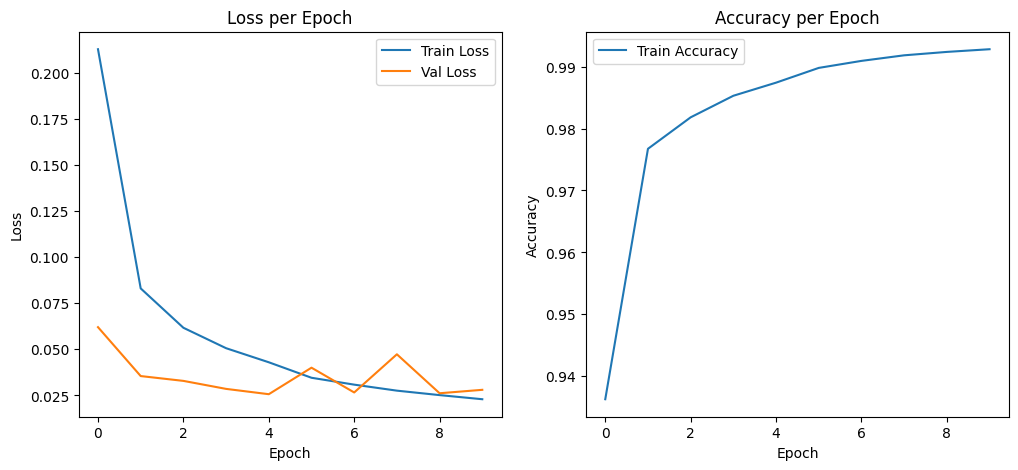

In [35]:
model = CNN() 
model.train_model(train_loader, test_loader, epochs=10, lr=0.001)